# 스태킹 앙상블

Stacking
- 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 Bagging, Boosting과 유사하지만, 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 차이점을 가짐
- 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML algorithm으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행. (메타 모델이라고도 부름)
- 따라서 두 종류의 모델이 필요함
  - 개별적인 기반 모델 (많이많이 필요함 두세개로는 별 차이 없음)
  - 최종 메타 모델
- 현실 모델에 적용하는 경우는 별로 없음. 캐글 같은 대회에서 영끌할 때나 씀

간단한 다이어그램
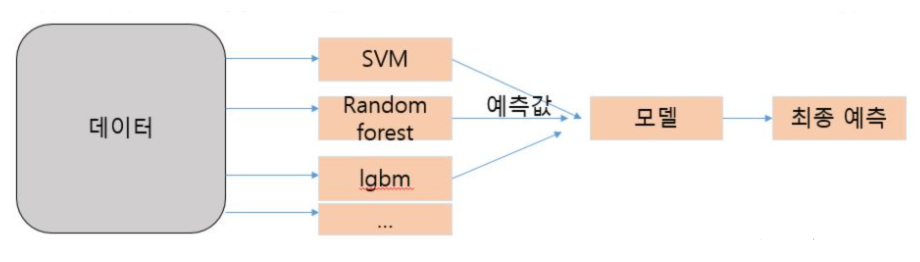

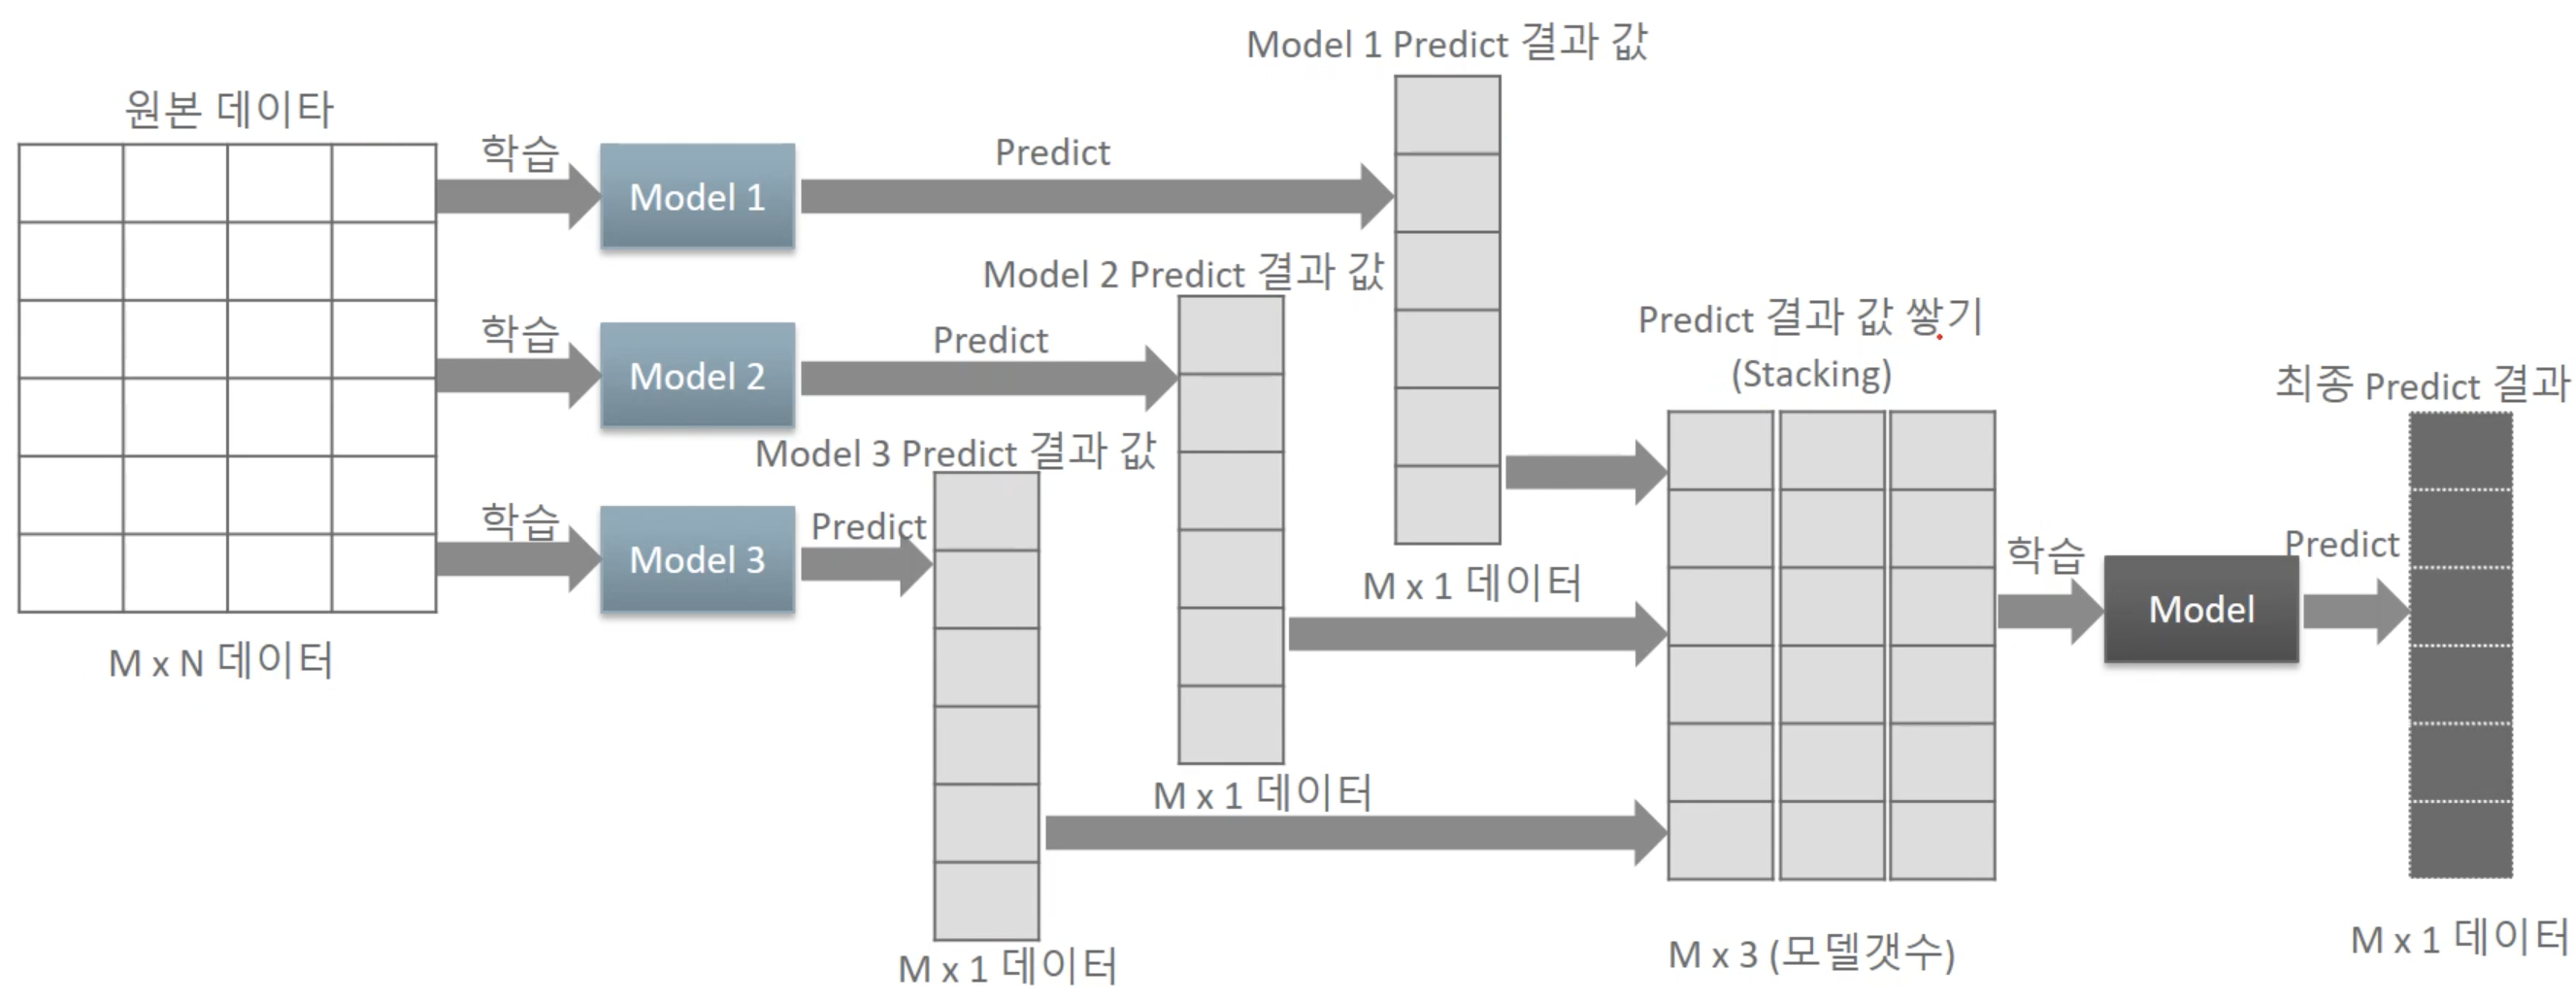

### 기본 스태킹 모델

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)


In [ ]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


개별 알고리즘으로부터 예측된 예측값을 새 column으로 붙여서 feature 값으로 만들어서 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 사용할 거임. 반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로, 반환된 예측 결과를 행 형태로 붙인 뒤 np의 transpose()를 이용해 행과 열 위치를 바꾼 ndarray로 변환할 것.

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


최종 메타 모델 학습 ㄱㄱ

In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9649


### CV 세트 기반의 스태킹

- 왜: 과적합 개선 (앞에서 로지스틱 회귀 모델로 최종 학습 할 때 label data set으로 학습 데이터가 아닌 테스트용 label data set을 기반으로 학습해서 과적합이 일어날 수 있음)
- 언제: 최종 메타 모델을 위한 데이터 세트를 만들 때
- 어떻게: 교차 검증 기반으로 예측된 결과 데이터 세트를 이용.

2단계의 스텝으로 구분 ㄱㄴ
1. 각 모델별로 원본 학습/테스트 데이터를 예측한 결과값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성
2. 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성. 마찬가지로 최종 테스트 데이터도 생성.

  메타 모델은 
  
  1) 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤,
  
  2) 최종적으로 생성된 테스트 데이터 세트를 예측하고,
  
  3) 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함.

좀 더 자세히...

**STEP 1**
1. 학습용 데이터를 N개의 fold로 나눔: N-1개의 fold는 학습을 위한 data fold, 1개의 fold는 검증을 위한 data fold
2. 이렇게 나눈 N-1개의 fold를 기반으로 개별 모델 학습시킴
3. 학습된 개별 모델은 검증 fold 1개 데이터로 예측하고 결과 저장. 이러한 로직을 N번 반복하되 학습 데이터와 검증 데이터를 변경해가면서 학습 후 예측 결과를 별도로 저장. 만들어진 예측 데이터는 메타 모델을 학습시키는 학습 데이터로 사용됨
4. N-1개의 학습 fold 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값 생성. 마찬가지로 이러한 로직을 N번 반복하면서 이 예측값의 평균으로 최종 결과 생성, 이를 메타 모델을 위한 테스트 데이터로 사용. 


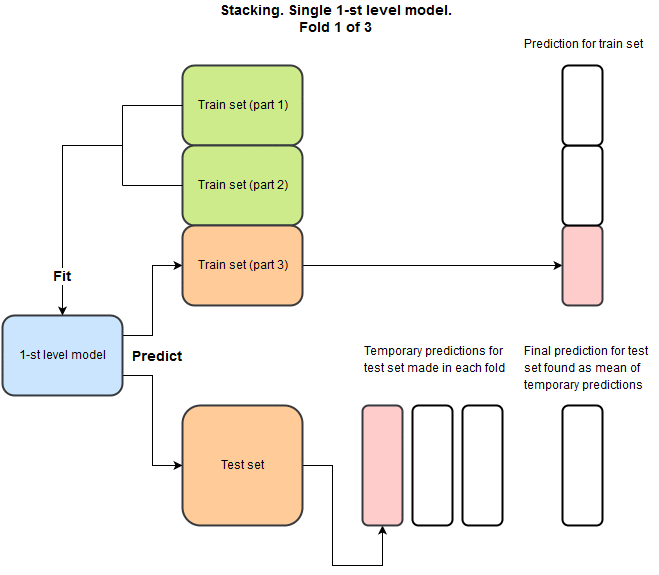

**STEP 2**
1. 각 모델들이 step 1로 생성한 학습/테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터를 생성
2. 메타 모델 학습시킴
3. 최종 테스트 데이터로 예측
4. 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가

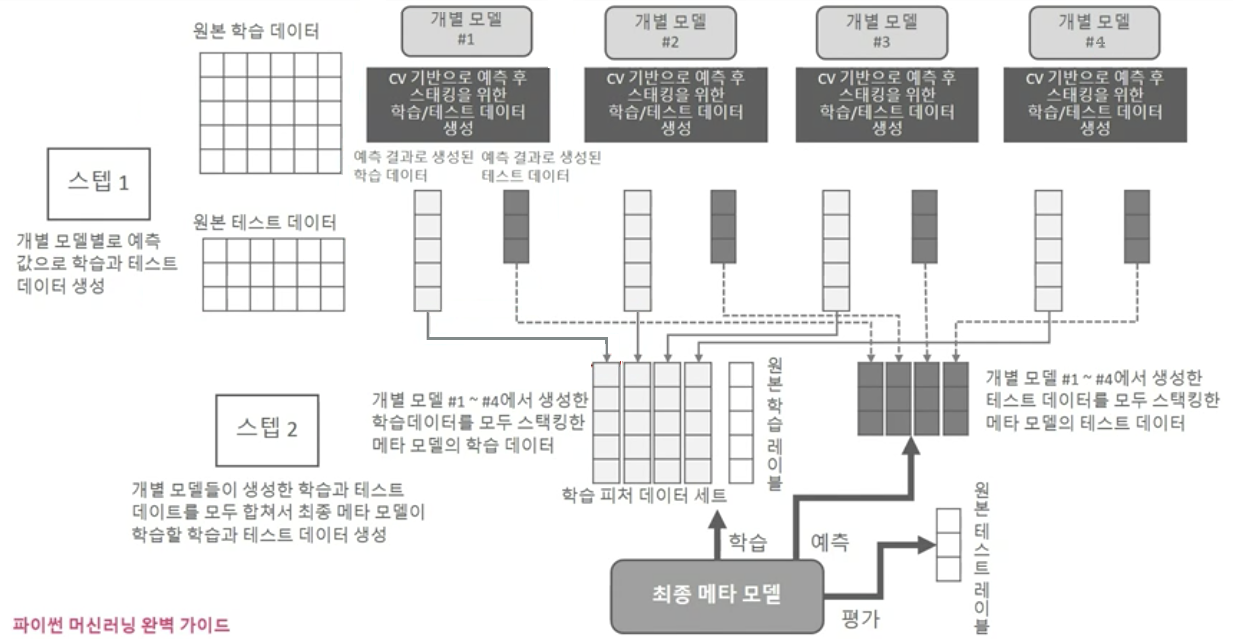

코드로 구현해보자.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

여러 개의 분류 모델별로 수행.

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


여기부터 STEP 2

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


스태킹 모델은 분류뿐만이 아닌 회귀에서도 이용 가능하다.